# Future weather models 

Create synthetic future weather data up to 2100 by using climate projections by DWD: 

https://www.dwd.de/DE/klimaumwelt/klimaatlas/klimaatlas_node.html;jsessionid=D84E870D1392681BE23498BDEFDD6364.live11043

1. Baseline model: no change relative to 1971-2000 average
2. Reserved model: slight changes
3. T-model: only T-changes, pronounced
4. P-model: only P-changes, pronounced
5. Mid model: Intermediate changes in P and T
6. Worst-case model: Extreme changes in P and T

Always calculate anomalies relative to baseline model.

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

pd.set_option('display.max_rows', 100)


## Load data

In [3]:
w = pd.read_csv('./data/weather_collections/weather_daily_region.csv')

# change date column to datetime type
w.date = pd.to_datetime(w.date)

# restrict data to the reference period 1971-2000
w = w.loc[w['date'] >= pd.to_datetime('1971-01-01')]
w = w.loc[w['date'] <= pd.to_datetime('2000-12-31')]

# set datetime index
w.set_index('date', inplace=True)
#w['date'] = w.index
w

,station_id_count,precip_mean,precip_min,precip_max,precip_std,tmean_mean,tmean_min,tmean_max,tmean_std,tmax_mean,...,tmax_max,tmax_std,tmin_mean,tmin_min,tmin_max,tmin_std,moisture_mean,moisture_min,moisture_max,moisture_std
date,,,,,,,,,,,,,,,,,,,,,
1971-01-01,7,0.028571,0.0,0.2,0.075593,-11.385714,-13.5,-10.2,1.175342,-6.228571,...,-4.4,1.443046,-14.471429,-17.5,-12.7,1.715337,83.000000,80.0,87.0,3.162278
1971-01-02,7,0.400000,0.0,1.0,0.424264,-8.042857,-9.3,-7.4,0.723089,-6.257143,...,-5.5,0.475595,-14.828571,-17.5,-12.1,1.829129,82.333333,79.0,88.0,3.076795
1971-01-03,7,0.757143,0.2,2.0,0.618755,-5.857143,-6.5,-4.7,0.699660,-4.628571,...,-2.7,1.338798,-8.242857,-10.1,-7.3,1.008063,86.500000,84.0,93.0,3.271085
1971-01-04,7,0.128571,0.0,0.5,0.179947,-5.414286,-6.2,-4.7,0.636209,-4.057143,...,-2.5,0.832380,-6.171429,-7.3,-5.2,0.809762,88.000000,84.0,94.0,3.794733
1971-01-05,7,0.000000,0.0,0.0,0.000000,-9.100000,-12.7,-7.3,1.940790,-5.414286,...,-4.0,0.971989,-11.357143,-15.0,-8.6,2.428894,87.666667,85.0,91.0,2.658320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-27,5,1.320000,0.0,1.9,0.828855,4.520000,4.0,5.2,0.540370,6.820000,...,8.2,0.861394,1.360000,0.2,2.6,1.080740,95.000000,93.0,98.0,2.000000
2000-12-28,5,0.060000,0.0,0.2,0.089443,3.100000,0.0,4.3,1.752142,5.920000,...,6.8,0.653452,1.260000,-1.5,2.7,1.697940,78.200000,71.0,90.0,7.596052
2000-12-29,5,4.280000,3.0,6.5,1.347961,0.160000,-1.4,1.0,0.928978,2.560000,...,3.9,1.663731,-1.060000,-2.1,0.0,0.756968,95.200000,92.0,97.0,1.923538


<Axes: xlabel='date', ylabel='tmean_mean'>

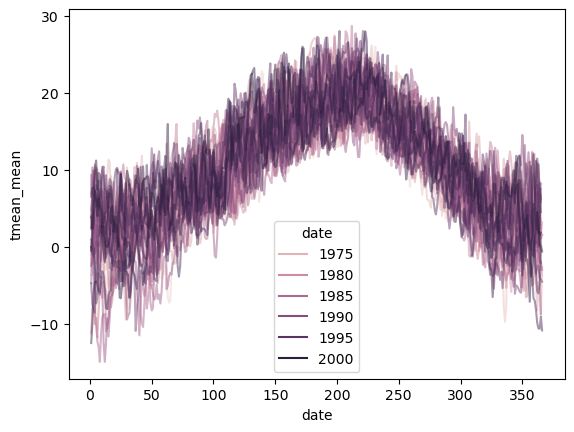

In [4]:
sns.lineplot(data=w, x=w.index.dayofyear, y='tmean_mean',
             hue=w.index.year,
             alpha=0.5)
#plt.xlim(pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31'))
#plt.xlim(0,365)

## Create reference year

First iteration only with average values. Later try more elaborate calculations.

In [5]:
#def calc_precip_mean(s):
#    return s.mean() + 20

In [6]:
#ref_year = w.groupby(by=[w.index.month.rename('month'),
#                         w.index.day.rename('day')]
#                    ).agg({'precip_mean': calc_precip_mean,
                          #'': '',
#                          'tmean_mean': 'mean'})

#ref_year.reset_index(inplace=True)

In [28]:
ref_year = w.groupby(by=[w.index.month.rename('month'),
                         w.index.day.rename('day')]
                    ).agg({'precip_mean': 'mean',
                          'moisture_mean': 'mean',
                          'tmean_mean': 'mean'})

ref_year.reset_index(inplace=True)

In [36]:
ref_year['month'] = ref_year['month'].astype(str).str.zfill(2)
ref_year['day'] = ref_year['day'].astype(str).str.zfill(2)
ref_year['month_day'] = ref_year['month'] + '-' + ref_year['day']

In [37]:
ref_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          366 non-null    object 
 1   day            366 non-null    object 
 2   precip_mean    366 non-null    float64
 3   moisture_mean  366 non-null    float64
 4   tmean_mean     366 non-null    float64
 5   month_day      366 non-null    object 
dtypes: float64(3), object(3)
memory usage: 17.3+ KB


Leap years are a problem. The below code generates the proper dates for the specified time period, including leap years. To create synthetic data:

1. create date column
2. create month-day column
3. join with artificial data table on the month-day column

In [48]:
# Create a date range from 2020 to 2030 with daily frequency
date_range = pd.date_range(start='2020-01-01', end='2030-12-31', freq='D')

# Create a DataFrame with the date range as the index
df = pd.DataFrame(index=date_range)
df['date'] = df.index

In [49]:
df['month_day'] = df.index.strftime('%m-%d')
df.head()

,date,month_day
2021-01-01,2021-01-01,01-01
2021-01-02,2021-01-02,01-02
2021-01-03,2021-01-03,01-03
2021-01-04,2021-01-04,01-04
2021-01-05,2021-01-05,01-05


In [50]:
synth = pd.merge(df, ref_year, 
                left_on='month_day', right_on='month_day',
                how='left',
                #left_index=True
                ).set_index(df['date'])

#synth.index.rename('date')
synth = synth.drop(['month_day', 'month', 'day'], axis=1)
synth

,date,precip_mean,moisture_mean,tmean_mean
date,,,,
2021-01-01,2021-01-01,1.648532,84.921627,0.440623
2021-01-02,2021-01-02,1.958282,86.353730,1.405563
2021-01-03,2021-01-03,2.445984,82.955595,1.789440
2021-01-04,2021-01-04,1.865794,83.210635,1.421913
2021-01-05,2021-01-05,2.433579,82.913690,1.622044
...,...,...,...,...
2030-12-27,2030-12-27,1.820417,83.405556,2.552004
2030-12-28,2030-12-28,1.316032,83.336786,2.461000
2030-12-29,2030-12-29,2.222389,84.247024,1.648060


<Axes: xlabel='date', ylabel='tmean_mean'>

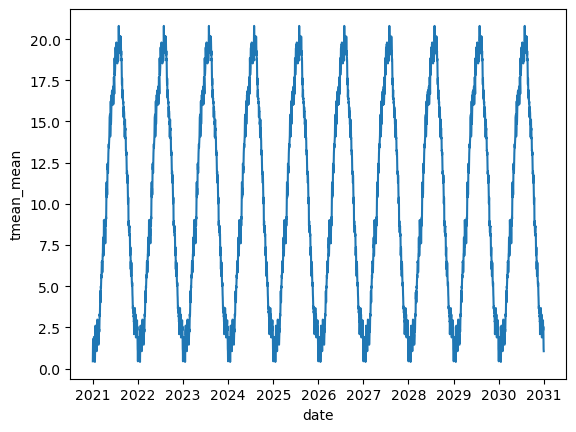

In [54]:
sns.lineplot(data=synth, x='date', y='tmean_mean')